In [37]:
from fastai.vision.all import *
import pandas as pd
import os

In [3]:
dir_path = 'data/images/'
train_path = 'data/images/train/'
classes = ['0', '1']

# Define the DataBlock
roads = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(460),
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
)


# Load the training data
dls = roads.dataloaders(train_path, bs=32)

In [4]:
# Initialize and train the model
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy, error_rate]).to_fp16()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.839116,0.360910,0.860870,0.139130,02:39
1,0.613210,0.306949,0.880745,0.119255,02:10
2,0.458998,0.199497,0.906832,0.093168,02:57
3,0.412627,0.189753,0.924224,0.075776,02:39
4,0.389983,0.182907,0.929193,0.070807,02:23


c:\Users\Giles\miniconda3\envs\vision\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [5]:
# Confirm training accuracy
from sklearn.metrics import accuracy_score

In [6]:
predictions, targets = learn.get_preds(ds_idx=1)
accuracy = accuracy_score(targets, predictions.argmax(dim=-1))
print("Test Accuracy:", accuracy)

Test Accuracy: 0.929192546583851


In [9]:
# Save the model
learn.save('saved-2')

Path('models/saved-2.pth')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.444997,0.431521,0.858385,0.141615,02:43
1,0.347815,0.337165,0.910559,0.089441,02:44
2,0.286184,0.143089,0.947826,0.052174,02:54
3,0.200886,0.098256,0.965217,0.034783,02:21


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

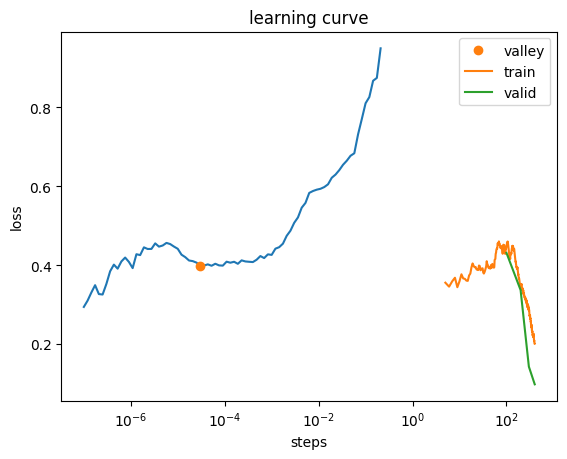

In [10]:
# Fine-tune the model
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(4, lr_max=slice(2e-4, 2e-3))
learn.recorder.plot_loss()

[('1', '0', 19), ('0', '1', 9)]


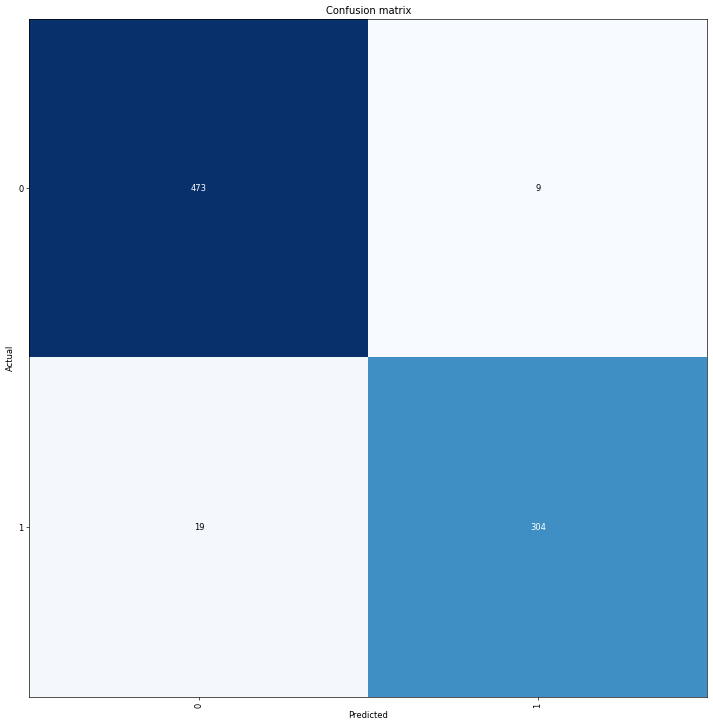

In [11]:
# Interpret the results
results = ClassificationInterpretation.from_learner(learn)
results.plot_confusion_matrix(figsize=(12, 12), dpi=60)
print(results.most_confused(min_val=3))

In [40]:
# Load the test data
test_path = 'data/images/'  # Base path to the test images
test_files = pd.read_csv("data/test_ids_only.csv")['Image_ID'].tolist()  # Assuming the CSV has a column named 'Image_ID'

# Append .jpg extension and prepend the base path to each filename
test_files = [os.path.join(test_path, f"{f}.jpg") for f in test_files]

# Check if test_files list is empty
if not test_files:
    raise ValueError("No JPG files found in the test set. Please check the file paths and ensure the test CSV contains JPG filenames.")

# Create a DataLoader for the test set
try:
    test_dl = learn.dls.test_dl(test_files)
except IndexError as e:
    raise IndexError("An error occurred while creating the test DataLoader. Check if the files exist and are accessible.") from e



In [41]:
# Make predictions on the test set
preds, _ = learn.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=-1)

# Create the submission DataFrame
submission = pd.DataFrame({
    'filename': [os.path.basename(f) for f in test_files],  # Just the filenames, not the full paths
    'label': pred_labels.numpy()
})

# Save the submission DataFrame to a CSV file
submission_file = 'submission.csv'

# Check if the file exists and create it if it doesn't
if not os.path.exists(submission_file):
    open(submission_file, 'w').close()

# Save the DataFrame to CSV
submission.to_csv(submission_file, index=False)
print("Submission CSV created successfully!")

c:\Users\Giles\miniconda3\envs\vision\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Submission CSV created successfully!


Submission 2

In [42]:
# Load the test data
test_path = 'data/images/'  # Base path to the test images
test_ids = pd.read_csv("data/test_ids_only.csv")['Image_ID'].tolist()  # Assuming the CSV has a column named 'Image_ID'

In [43]:
# Append .jpg extension and prepend the base path to each filename
test_files = [os.path.join(test_path, f"{img_id}.jpg") for img_id in test_ids]

# Check if test_files list is empty
if not test_files:
    raise ValueError("No JPG files found in the test set. Please check the file paths and ensure the test CSV contains JPG filenames.")

# Create a DataLoader for the test set
try:
    test_dl = learn.dls.test_dl(test_files)
except IndexError as e:
    raise IndexError("An error occurred while creating the test DataLoader. Check if the files exist and are accessible.") from e

In [44]:
# Make predictions on the test set (getting probabilities)
preds, _ = learn.get_preds(dl=test_dl)
probs = preds.softmax(dim=-1)[:, 1]  # Assuming the second column is the probability of observing a pothole

# Create the submission DataFrame
submission = pd.DataFrame({
    'Image_ID': test_ids,  # Use the original image IDs without the .jpg extension
    'Probability': probs.numpy()
})

# Save the submission DataFrame to a CSV file
submission_file = 'submission_2.csv'

# Check if the file exists and create it if it doesn't
if not os.path.exists(submission_file):
    open(submission_file, 'w').close()

# Save the DataFrame to CSV
submission.to_csv(submission_file, index=False)
print("Submission CSV created successfully!")

Submission CSV created successfully!
